In [78]:
import numpy as np
import pyuvdata
from newcal import calibration_wrappers, caldata, calibration_optimization, cost_function_calculations
import importlib
importlib.reload(calibration_wrappers)
importlib.reload(caldata)
importlib.reload(calibration_optimization)
importlib.reload(cost_function_calculations)
import matplotlib.pyplot as plt

In [79]:
data_path = (
    f"/Users/ruby/Downloads/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
)
model_path = f"/Users/ruby/Downloads/zen.2459861.45004.sum.abs_calibrated.red_avg_model.uvfits"
data = pyuvdata.UVData()
data.read(data_path)
model = pyuvdata.UVData()
model.read(model_path)

use_frequencies = list(set(data.freq_array[0, :]))[0:20]
data.select(frequencies=use_frequencies)
model.select(frequencies=use_frequencies)

data.inflate_by_redundancy(use_grid_alg=True)
model.inflate_by_redundancy(use_grid_alg=True)

# Model does not include all baselines
model_baselines = list(set(list(zip(model.ant_1_array, model.ant_2_array))))
data_baselines = list(set(list(zip(data.ant_1_array, data.ant_2_array))))
use_baselines = [
    baseline
    for baseline in model_baselines
    if (baseline in data_baselines) or (baseline[::-1] in data_baselines)
]
use_polarizations = -5
data.select(bls=use_baselines, polarizations=use_polarizations)
model.select(bls=use_baselines, polarizations=use_polarizations)

# Align phasing
data.phase_to_time(np.mean(data.time_array))
model.phase_to_time(np.mean(data.time_array))

data.compress_by_redundancy()
model.compress_by_redundancy()


Selected frequencies are not evenly spaced. This will make it impossible to write this data out to some file types
Selected frequencies are not evenly spaced. This will make it impossible to write this data out to some file types
Missing some redundant groups. Filling in available data.
Missing some redundant groups. Filling in available data.
divide by zero encountered in divide


In [106]:
caldata_obj = caldata.CalData()
caldata_obj.load_data(
    data,
    model,
)

divide by zero encountered in divide


In [107]:
caldata_obj.dwcal_inv_covariance = np.zeros(
    (
        caldata_obj.Ntimes,
        caldata_obj.Nbls,
        caldata_obj.Nfreqs,
        caldata_obj.Nfreqs,
        caldata_obj.N_vis_pols,
    ),
    dtype=complex,
)
for freq_ind in range(caldata_obj.Nfreqs):
    caldata_obj.dwcal_inv_covariance[:, :, freq_ind, freq_ind, :] = 1.0 + 1j * 0.0

In [108]:
hess = calibration_optimization.hessian_dw_abscal_wrapper(
    caldata_obj.abscal_params.flatten(), range(caldata_obj.Nfreqs), caldata_obj
)
print(np.shape(hess))
print(hess)

(60, 60)
[[1.42378912e+09 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.28055632e+09 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.02373846e+09 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.84661569e+08
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.99361993e+08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.84969461e+08]]


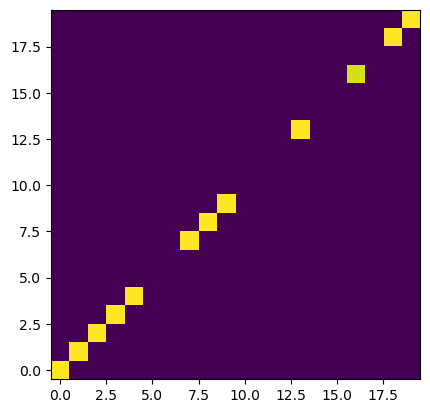

In [109]:
plt.imshow(hess[20:40,40:60], interpolation=None, origin="lower", vmin=0, vmax=1e7)

In [110]:
caldata_list = caldata_obj.expand_in_frequency()

In [112]:
calibration_optimization.run_dw_abscal_optimization(
    caldata_obj,
    1e-6,
    100,
    verbose=True,
)

abscal_params_per_freq = np.zeros((3, caldata_obj.Nfreqs))
for freq in range(caldata_obj.Nfreqs):
    calibration_optimization.run_abscal_optimization_single_freq(
        caldata_list[freq],
        1e-6,
        100,
        verbose=True,
        return_abscal_params=False,
    )
    abscal_params_per_freq[:, freq] = caldata_list[freq].abscal_params[:, 0, 0]

DWAbscal cost: 1533660553.6465638
DWAbscal cost: 1533660553.6465251
Optimization terminated successfully.
         Current function value: 1533660553.646525
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 1
Optimization terminated successfully.
Optimization time: 0.0013399163881937662 minutes
Optimization terminated successfully.
         Current function value: 381472143.592859
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 1
Optimization terminated successfully.
Optimization time: 2.5383631388346355e-05 minutes
Optimization terminated successfully.
         Current function value: 442810997.237129
         Iterations: 7
         Function evaluations: 11
         Gradient evaluations: 11
         Hessian evaluations: 7
Optimization terminated successfully.
Optimization time: 6.603399912516275e-05 minutes
Optimization terminated successfully.
  

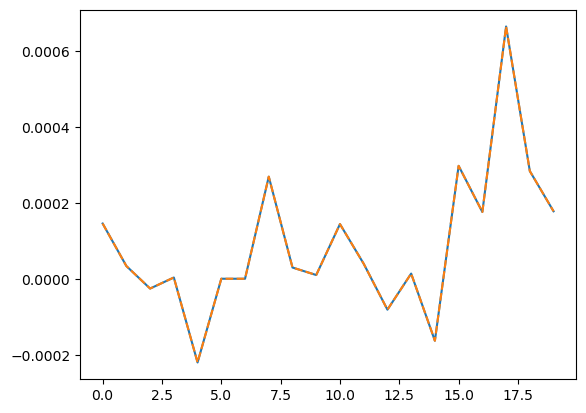

In [116]:
plt.plot(caldata_obj.abscal_params[2, :])
plt.plot(abscal_params_per_freq[2, :], "--")

In [83]:
test_pol_ind = 0
(
    hess_amp_amp,
    hess_amp_phasex,
    hess_amp_phasey,
    hess_phasex_phasex,
    hess_phasey_phasey,
    hess_phasex_phasey,
) = cost_function_calculations.hess_dw_abscal(
    caldata_obj.abscal_params[0, :, test_pol_ind],
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)

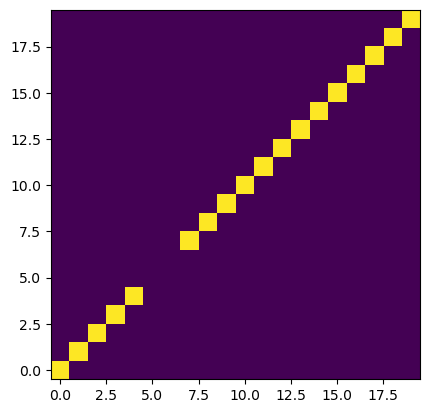

In [99]:
plt.imshow(
    np.abs(hess_phasex_phasey), interpolation=None, origin="lower", vmin=0, vmax=1e-5
)

In [24]:
print(np.shape(hess2[0, :, :]))

TypeError: tuple indices must be integers or slices, not tuple

In [65]:
def hess_phasex_phasex(
    amp,
    phase_grad,
    model_visibilities,
    data_visibilities,
    uv_array,
    visibility_weights,
    dwcal_inv_covariance,
):
    phase_term = np.sum(
        phase_grad[np.newaxis, :, :] * uv_array[:, :, np.newaxis], axis=1
    )  # Shape (Nbls, Nfreqs,)
    res_vec = np.sqrt(visibility_weights) * (
        (amp[np.newaxis, :] ** 2.0 * np.exp(1j * phase_term))[np.newaxis, :, :]
        * data_visibilities
        - model_visibilities
    )  # Shape (Ntimes, Nbls, Nfreqs,)
    derivative_term = (
        np.sqrt(visibility_weights)
        * np.exp(-1j * phase_term)[np.newaxis, :, :]
        * np.conj(data_visibilities)
    )  # Shape (Ntimes, Nbls, Nfreqs,)
    no_diag = (
        2
        * amp[:, np.newaxis] ** 2.0
        * amp[np.newaxis, :] ** 2.0
        * np.real(
            np.sum(
                dwcal_inv_covariance  
                * uv_array[np.newaxis, :, np.newaxis, np.newaxis, 0]
                ** 2.0  
                * derivative_term[:, :, np.newaxis, :]  
                * np.conj(derivative_term[:, :, :, np.newaxis]),
                axis=(0, 1),
            )
        )
    )
    diag = (
        -2
        * amp ** 2.0
        * np.real(
            np.sum(
                dwcal_inv_covariance  # Shape (Ntimes, Nbls, Nfreqs, Nfreqs,)
                * uv_array[np.newaxis, :, np.newaxis, np.newaxis, 0]
                ** 2.0  # Shape (1, Nbls, 1, 1)
                * derivative_term[
                    :, :, :, np.newaxis
                ]  # Shape (Ntimes, Nbls, Nfreqs, 1)
                * res_vec[:, :, np.newaxis, :],  # Shape (Ntimes, Nbls, 1, Nfreqs,)
                axis=(0, 1, 3),
            )
        )
    )
    return no_diag + np.diag(diag)

In [66]:
phasex_phasex_no_diag = hess_phasex_phasex(
    caldata_obj.abscal_params[0, :, test_pol_ind],
    caldata_obj.abscal_params[1:, :, test_pol_ind],
    caldata_obj.model_visibilities[:, :, :, test_pol_ind],
    caldata_obj.data_visibilities[:, :, :, test_pol_ind],
    caldata_obj.uv_array,
    caldata_obj.visibility_weights[:, :, :, test_pol_ind],
    caldata_obj.dwcal_inv_covariance[:, :, :, :, test_pol_ind],
)

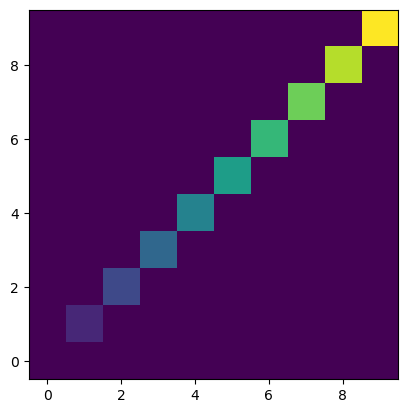

In [68]:
plt.imshow(np.diag(range(10)), interpolation=None, origin="lower", vmin=0)